In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

COINS = ['btc', 'eth']
DATA_DIR = '/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/snapshot_data'

In [ ]:
for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin}_full_data_transformed.csv')
    df = pd.read_csv(full_path)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
    df['coin'] = df['coin'].str.lower()
    df = df[df['coin'] == coin]

    df['date'] = df['timestamp'].dt.date
    num_days = df['date'].nunique()

    df['expiry'] = (pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    ttm_days = (df['expiry'] - df['timestamp']) / pd.Timedelta(days=1)
    df['DTE'] = (np.ceil(ttm_days) - 1).astype('Int64')

    all_unique = df['symbol'].nunique()
    avg_daily_0dte = (df[df['DTE']==0]
                  .groupby(df['timestamp'].dt.floor('D'))['symbol']
                  .nunique()
                  .mean())


    print(f"{coin.upper()} — Total unique contracts: {all_unique} on {num_days} days with on average {avg_daily_0dte:.2f} 0DTE contracts per day")

BTC — Total unique contracts: 13658 on 365 days with on average 66.79 0DTE contracts per day
ETH — Total unique contracts: 15952 on 365 days with on average 77.48 0DTE contracts per day


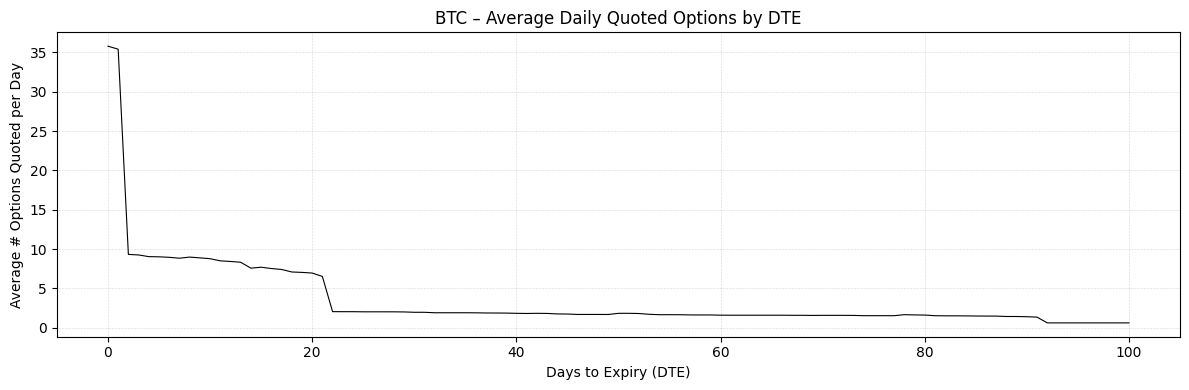

Unique Quoted DTEs for BTC: 372
Amount of 0DTE Options Quoted for BTC: 13068
Fraction of 0DTE Options Quoted for BTC: 7.24%
Average Daily Unique Quoted Options for BTC: 494.47
Average Daily Unique Quoted Options for 0DTE BTC: 35.80


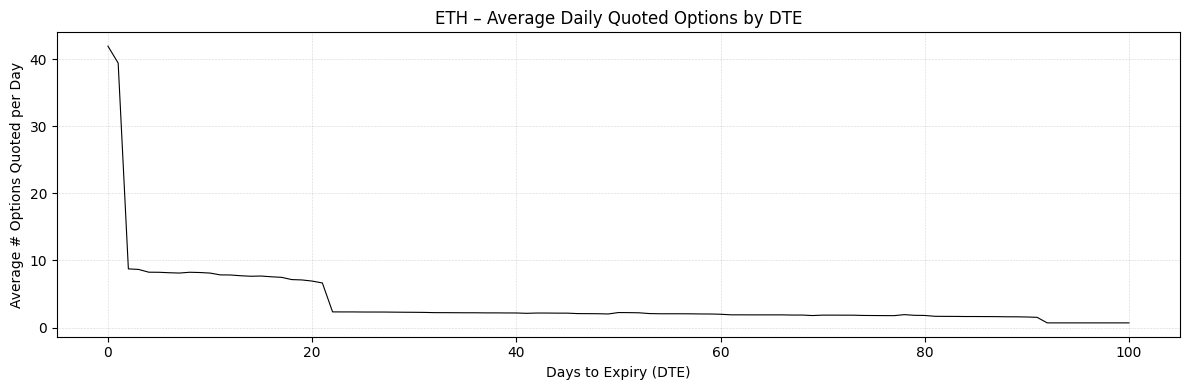

Unique Quoted DTEs for ETH: 372
Amount of 0DTE Options Quoted for ETH: 15300
Fraction of 0DTE Options Quoted for ETH: 7.96%
Average Daily Unique Quoted Options for ETH: 526.80
Average Daily Unique Quoted Options for 0DTE ETH: 41.92


In [2]:
for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin}_full_data_transformed.csv')

    df = pd.read_csv(full_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)   
    df['date'] = df['timestamp'].dt.date                          # extract the date
    unique_days = df['date'].nunique()   
    df[['coin', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)              

    # Parse expiry at 08:00 UTC
    expiry_date = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce')
    df['expiry'] = (expiry_date + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
    df = df[df['time_to_maturity'] > 0] # drop already‑expired rows
    
    ttm_days = df['time_to_maturity'] / 86_400
    df['DTE'] = (np.ceil(ttm_days) - 1).astype('Int64')

    # Count unique quoted option symbols per DTE
    dte_counts = df.groupby('DTE')['symbol'].nunique().sort_index()
    
    # Average the amount of options quoted per DTE over the unique days
    average_dte_counts = dte_counts / unique_days
    average_dte_counts_adj = average_dte_counts[average_dte_counts.index <= 100]

    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(average_dte_counts_adj.index, average_dte_counts_adj.values,
            color='black', linewidth=0.8, markersize=3, label='Avg Daily Unique Symbols')
    plt.title(f'{coin.upper()} – Average Daily Quoted Options by DTE')
    plt.xlabel('Days to Expiry (DTE)')
    plt.ylabel('Average # Options Quoted per Day')
    plt.grid(ls=':', lw=0.4, color='grey', alpha=.6)
    plt.tight_layout()
    plt.show()

    # Total stats
    print(f"Unique Quoted DTEs for {coin.upper()}: {len(dte_counts)}")
    print(f"Amount of 0DTE Options Quoted for {coin.upper()}: {dte_counts.get(0, 0)}")
    print(f"Fraction of 0DTE Options Quoted for {coin.upper()}: {dte_counts.get(0, 0) / dte_counts.sum():.2%}")

    # Average stats
    print(f"Average Daily Unique Quoted Options for {coin.upper()}: {average_dte_counts.sum():.2f}")
    print(f"Average Daily Unique Quoted Options for 0DTE {coin.upper()}: {average_dte_counts.get(0, 0):.2f}")


<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:61: SyntaxWarning: invalid escape sequence '\g'
/var/folders/j1/sv4t8szd51jgm826w2bv1vyr0000gn/T/ipykernel_51430/2256483042.py:61: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f'{coin}: Percentage of Days with $\geq$ {THRESHOLD} Distinct 0DTE Quotes', fontsize=11)


Data processing complete.


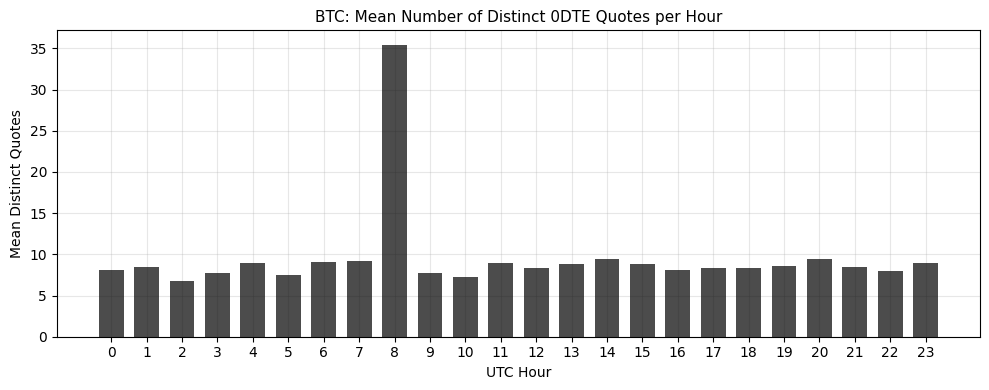

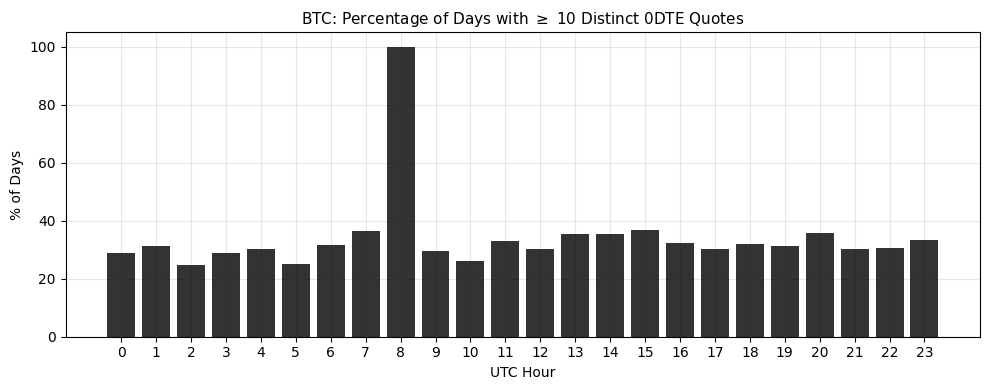

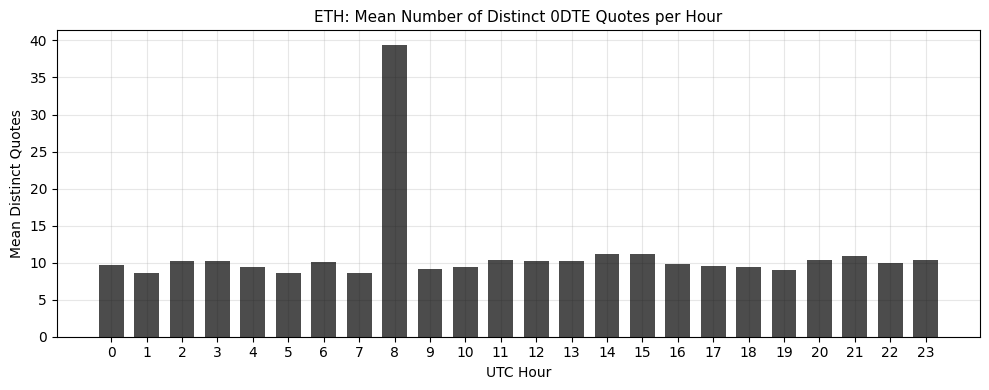

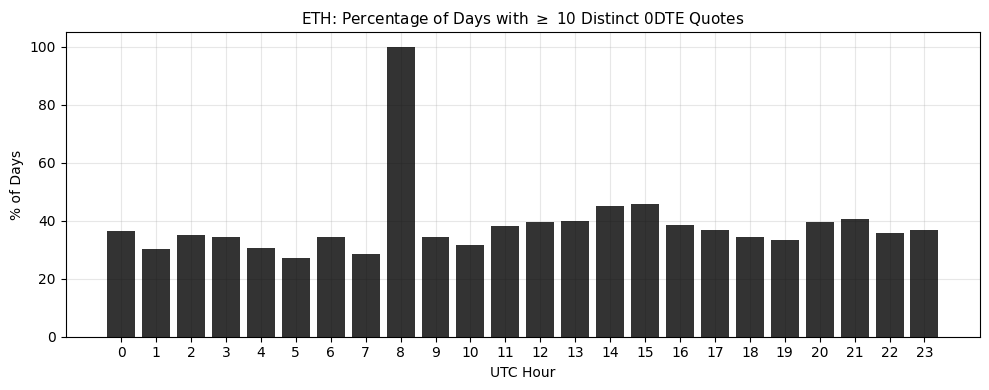

In [ ]:
DATA_DIR = "/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/snapshot_data"
THRESHOLD = 10
COINS = ['btc', 'eth']
hours = np.arange(24)
hour_labels = [f'{h:02d}:00' for h in hours]
mean_quotes_per_hour = {}
pct_days_above_threshold = {}

for coin in COINS:
    fp = os.path.join(DATA_DIR, f"{coin}_full_data_transformed.csv")
    if not os.path.exists(fp):
        print(f"Warning: File not found for {coin.upper()}, skipping.")
        continue
    df = pd.read_csv(fp)

    # Convert timestamps and extract date/hour components
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    
    # Parse symbol to get option details
    df[['coin_symbol', 'exp_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
    expiry_date = pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce')
    df['expiry'] = (expiry_date + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
    
    # Filter for 0DTE options (time to maturity <= 1 day)
    df = df[(df['time_to_maturity'] > 0) & (df['time_to_maturity'] <= 86400)]
    if df.empty:
        continue

    # Pivot data to get counts of unique options per hour for each day
    pivot = df.groupby(['date', 'hour'])['symbol'].nunique().unstack(fill_value=0)
    
    # Calculate metrics
    mean_quotes_per_hour[coin.upper()] = pivot.mean().reindex(hours, fill_value=0).values
    pct_above_threshold = (pivot >= THRESHOLD).sum(axis=0) / pivot.shape[0] * 100
    pct_days_above_threshold[coin.upper()] = pct_above_threshold.reindex(hours, fill_value=0).values

print("Data processing complete.")

plot_colors = {'BTC': 'black', 'ETH': 'black'} 
for coin in ['BTC', 'ETH']:
    if coin not in mean_quotes_per_hour:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(hours, mean_quotes_per_hour[coin], color=plot_colors[coin], width=0.7, alpha=0.7, zorder=10)
    ax.set_ylabel('Mean Distinct Quotes')
    ax.set_title(f'{coin}: Mean Number of Distinct 0DTE Quotes per Hour', fontsize=11)
    ax.set_xticks(hours)
    ax.set_xlabel('UTC Hour')
    ax.grid(True, linestyle='-', alpha=0.3, zorder=0)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(hours, pct_days_above_threshold[coin], color=plot_colors[coin], width=0.8, alpha=0.8, zorder=10)
    ax.set_ylabel('% of Days')
    ax.set_title(f'{coin}: Percentage of Days with $\geq$ {THRESHOLD} Distinct 0DTE Quotes', fontsize=11)
    ax.set_xlabel('UTC Hour')
    ax.set_xticks(hours)
    ax.grid(True, linestyle='-', alpha=0.3, zorder=0)    
    ax.set_ylim(0, 105)
    plt.tight_layout()
    plt.show()


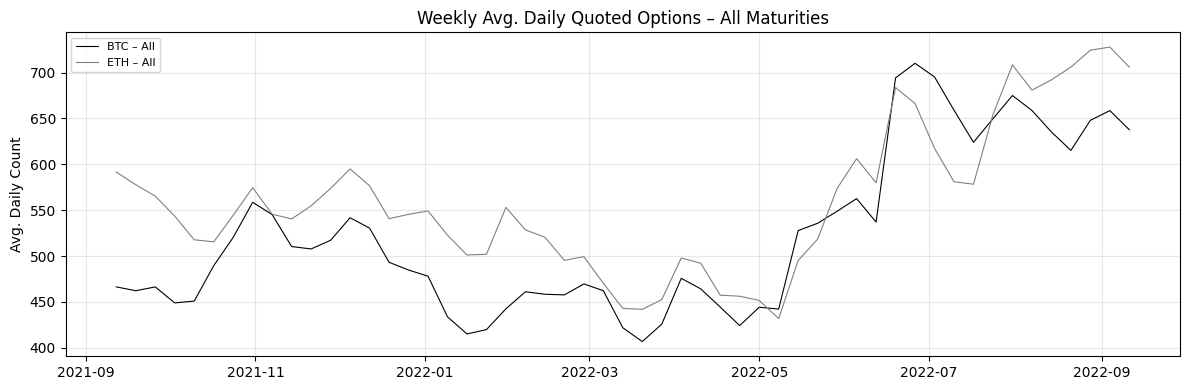

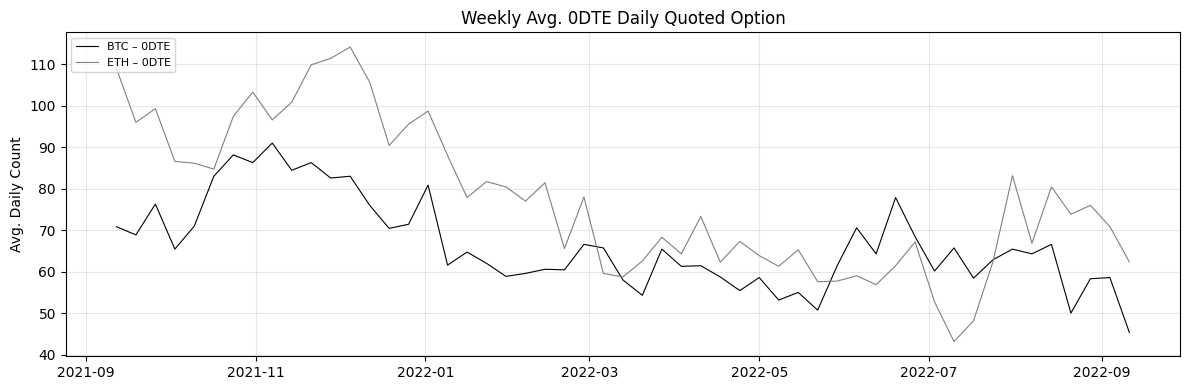

In [ ]:
UTC_HOUR = 3
COINS    = ['btc', 'eth']
colors   = {'BTC': 'black', 'ETH': 'gray'}

weekly_all  = {}
weekly_0dte = {}

for coin in COINS:
    fp = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')
    df = pd.read_csv(fp)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df['date']      = df['timestamp'].dt.floor('D').dt.tz_localize(None)  
    df['exp_raw'] = df['symbol'].str.split('-', expand=True)[1]
    df['expiry'] = (pd.to_datetime(df['exp_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')

    # exact time to maturity in days 
    df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
    df = df[df['time_to_maturity'] > 0] # drop expired rows

    df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')    

    daily_all = df.groupby('date')['symbol'].nunique()
    daily_all.index = pd.to_datetime(daily_all.index)         
    weekly_all[coin.upper()] = daily_all.resample('W').mean()

    df_0dte = df[df['DTE'] < 1]
    daily_0dte = df_0dte.groupby('date')['symbol'].nunique()
    daily_0dte.index = pd.to_datetime(daily_0dte.index)
    weekly_0dte[coin.upper()] = daily_0dte.resample('W').mean()

plt.figure(figsize=(12, 4))
for coin in ['BTC', 'ETH']:
    plt.plot(weekly_all[coin].index, weekly_all[coin].values,
             lw=0.8, color=colors[coin], label=f'{coin} – All')
plt.title('Weekly Avg. Daily Quoted Options – All Maturities')
plt.ylabel('Avg. Daily Count')
plt.grid(True, linestyle='-', alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for coin in ['BTC', 'ETH']:
    plt.plot(weekly_0dte[coin].index, weekly_0dte[coin].values,
             lw=0.8, color=colors[coin], label=f'{coin} – 0DTE')
plt.title(f'Weekly Avg. 0DTE Daily Quoted Option')
plt.ylabel('Avg. Daily Count')
plt.grid(True, linestyle='-', alpha=0.3)
plt.legend(fontsize=8, loc='upper left')
plt.tight_layout()
plt.show()



--- BTC at 08:00 UTC ---
365 out of 365 days had >= 10 contracts (100.00%)
Median: 30.0, Mean: 35.42, Std: 13.98, Min: 20, Max: 98


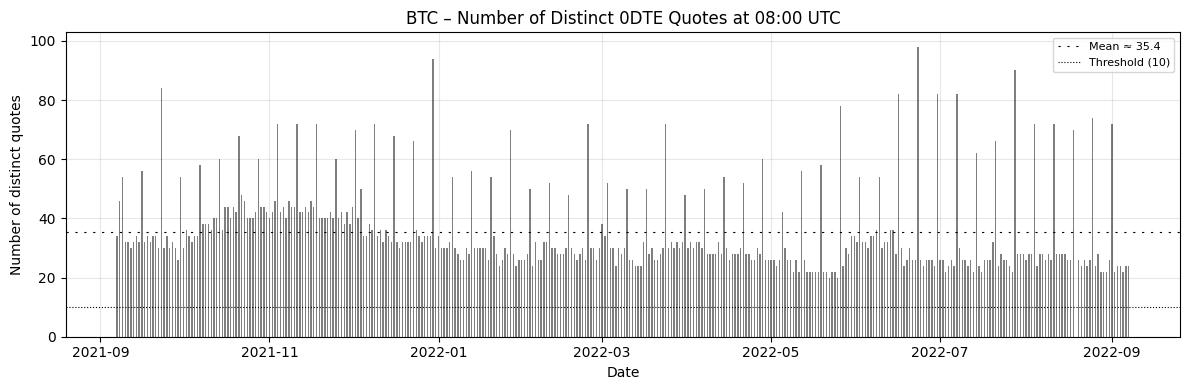

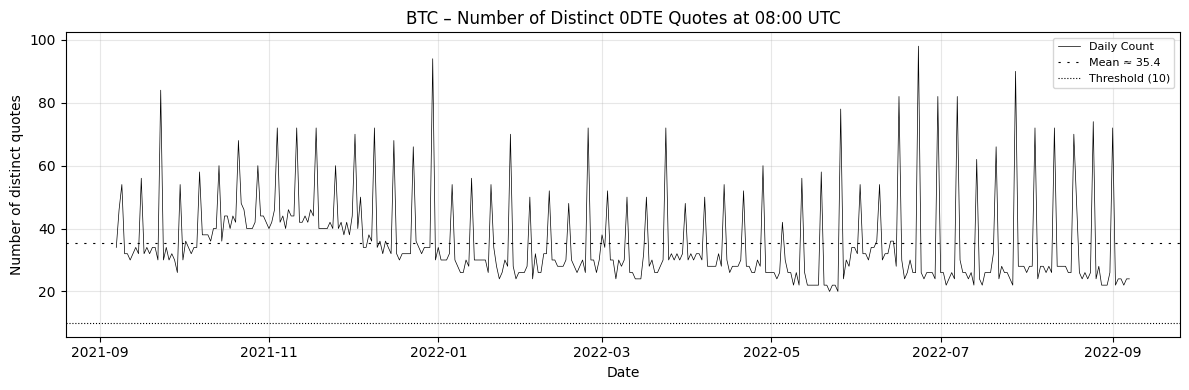


--- ETH at 08:00 UTC ---
365 out of 365 days had >= 10 contracts (100.00%)
Median: 38.0, Mean: 39.39, Std: 15.64, Min: 16, Max: 110


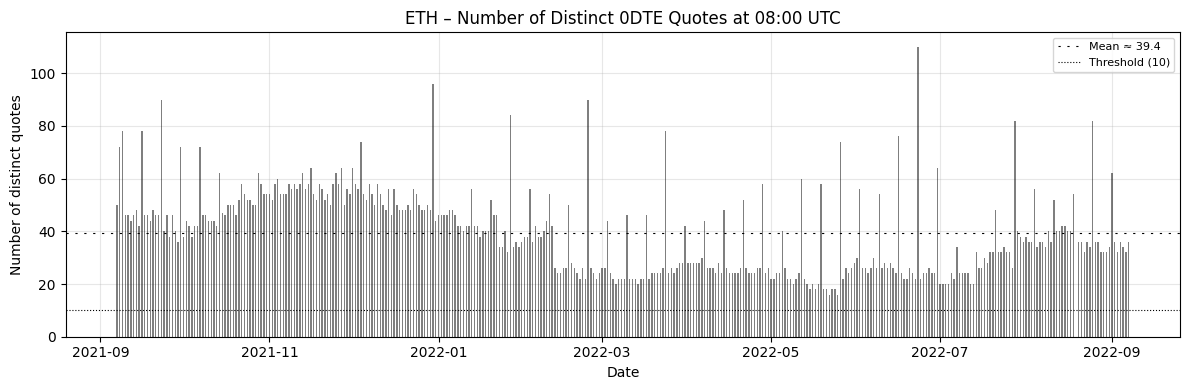

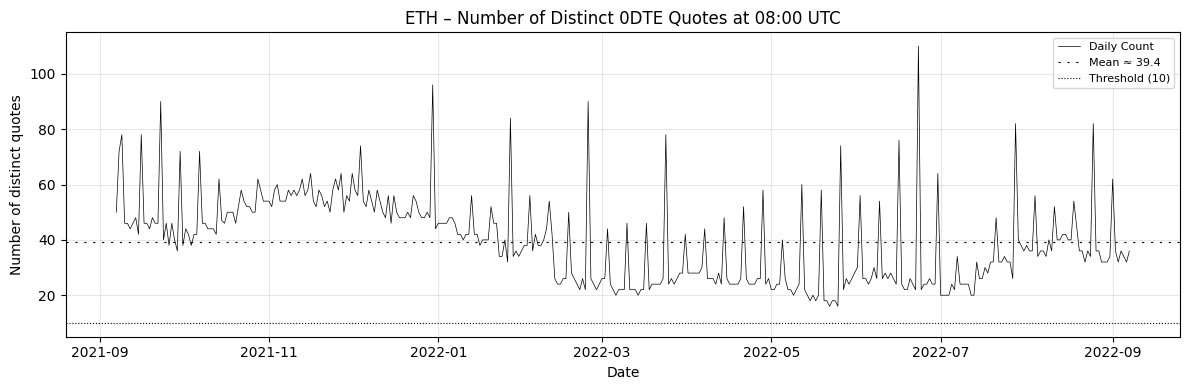

In [ ]:
DATA_DIR = "/Users/joris/Documents/Master QF/Thesis/optimal-gamma-hedging/Data/snapshot_data"
COINS = ['btc', 'eth']
UTC_HOUR   = 8
THRESHOLD  = 10

for coin in COINS:
    fp = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')
    if not os.path.exists(fp):
        print(f"Warning: File not found for {coin.upper()}, skipping.")
        continue
    df = pd.read_csv(fp)

    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
    df = df[(df['timestamp'].dt.hour == UTC_HOUR) &
            (df['timestamp'].dt.minute == 0)].copy()

    # Extract expiry and calculate time to maturity
    df['expiry_raw'] = df['symbol'].str.split('-', expand=True)[1]
    df['expiry'] = (pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
    df = df[df['time_to_maturity'] > 0] # Drop expired rows

    # Calculate DTE and filter for 0DTE
    df['DTE'] = (np.ceil(df['time_to_maturity'] / 86400) - 1).astype('Int64')    
    df = df[df['DTE'] == 0]

    if df.empty:
        print(f"⚠ No 0DTE data for {coin.upper()} at {UTC_HOUR:02d}:00 UTC")
        continue

    # Group by date to get daily unique option counts
    df['date'] = df['timestamp'].dt.date
    option_counts = df.groupby('date')['symbol'].nunique()
    option_counts.index = pd.to_datetime(option_counts.index)

    mean_val   = option_counts.mean()
    median_val = option_counts.median()
    std_val    = option_counts.std()
    min_val    = option_counts.min()
    max_val    = option_counts.max()
    days_above = (option_counts >= THRESHOLD).sum()
    
    print(f"\n--- {coin.upper()} at {UTC_HOUR:02d}:00 UTC ---")
    print(f"{days_above} out of {len(option_counts)} days had >= {THRESHOLD} contracts ({days_above/len(option_counts):.2%})")
    print(f"Median: {median_val}, Mean: {mean_val:.2f}, Std: {std_val:.2f}, Min: {min_val}, Max: {max_val}")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(option_counts.index, option_counts.values, color='black', alpha=0.5, width=0.5, zorder=2)
    ax.axhline(mean_val, color='black', linestyle=(0, (2, 6)), linewidth=0.8, label=f'Mean ≈ {mean_val:.1f}')
    ax.axhline(THRESHOLD, color='black', linestyle=':', linewidth=0.8, label=f'Threshold ({THRESHOLD})')
    ax.set_title(f'{coin.upper()} – Number of Distinct 0DTE Quotes at {UTC_HOUR:02d}:00 UTC')
    ax.set_ylabel('Number of distinct quotes')
    ax.set_xlabel('Date')
    ax.grid(True, linestyle='-', alpha=0.3, zorder=1)
    ax.legend(fontsize=8, loc='upper right')
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(option_counts.index, option_counts.values, color='black', linewidth=0.5, label='Daily Count')
    ax.axhline(mean_val, color='black', linestyle=(0, (2, 6)), linewidth=0.8, label=f'Mean ≈ {mean_val:.1f}')
    ax.axhline(THRESHOLD, color='black', linestyle=':', linewidth=0.8, label=f'Threshold ({THRESHOLD})')
    ax.set_title(f'{coin.upper()} – Number of Distinct 0DTE Quotes at {UTC_HOUR:02d}:00 UTC')
    ax.set_ylabel('Number of distinct quotes')
    ax.set_xlabel('Date')
    ax.grid(True, linestyle='-', alpha=0.3)
    ax.legend(fontsize=8, loc='upper right')
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    plt.tight_layout()
    plt.show()


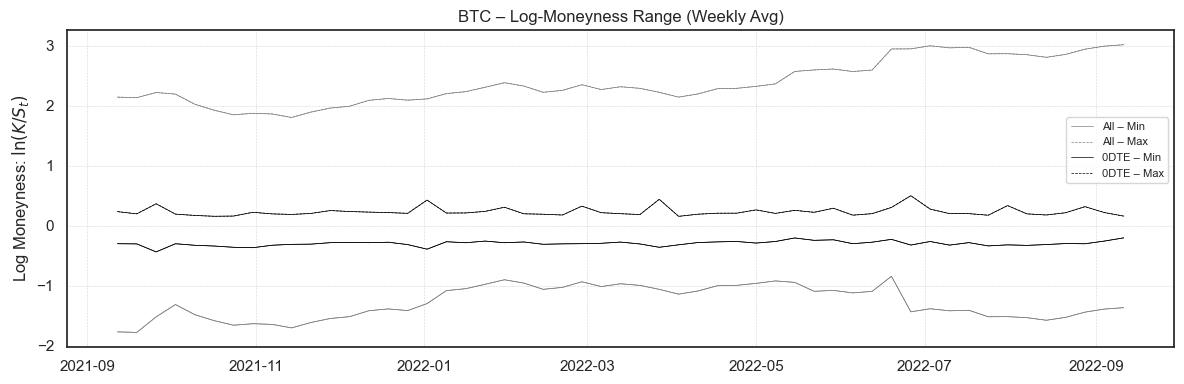

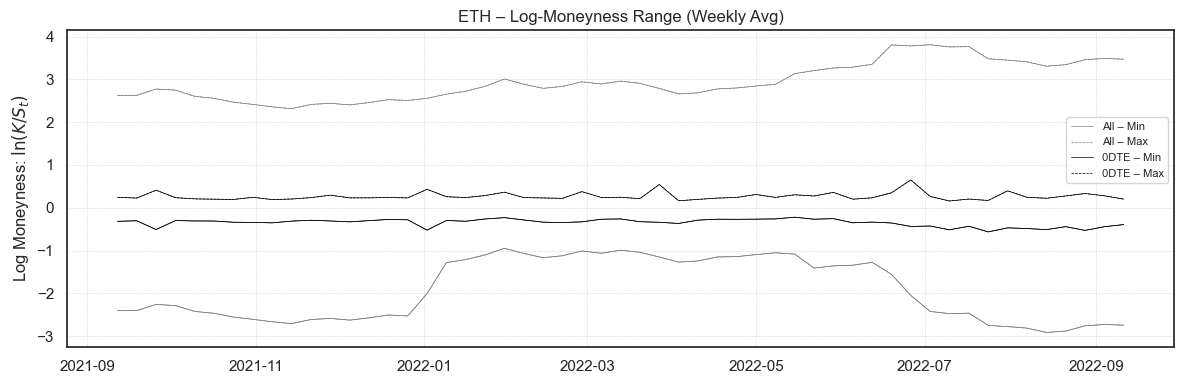

In [ ]:
UTC_HOUR = 8

for coin in COINS:
    full_path = os.path.join(DATA_DIR, f'{coin.upper()}_full_data_transformed.csv')

    df = pd.read_csv(full_path)
    df['F'] = df['spot']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)

    exp_raw = df['symbol'].str.split('-').str[1]
    df['expiry'] = (pd.to_datetime(exp_raw, format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
    df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
    df = df[df['time_to_maturity'] > 0] # drop expired rows
    df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')    

    snap_all = df[(df['timestamp'].dt.hour == UTC_HOUR) &
                  (df['timestamp'].dt.minute == 0)].copy()
    if snap_all.empty:
        print(f'No 08:00 UTC quotes for {coin.upper()}')
        continue
    snap_all['date'] = snap_all['timestamp'].dt.normalize()
    snap_all['std_mny'] = np.log(snap_all['strike'] / snap_all['F'])

    snap_0dte = snap_all[snap_all['DTE'] == 0].copy()
    def summarise(df_):
        daily = (df_.groupby('date')['std_mny']
                    .agg(['min', 'max'])
                    .dropna())
        return daily.resample('W').mean()   

    weekly_all  = summarise(snap_all)
    weekly_0dte = summarise(snap_0dte)

    plt.figure(figsize=(12, 4))

    # All quotes 
    plt.plot(weekly_all.index,  weekly_all['min'], '-', color='gray',   label='All – Min', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['max'], '--', color='gray',   label='All – Max', linewidth=0.5)

    # 0DTE quotes 
    plt.plot(weekly_0dte.index, weekly_0dte['min'], '-', color='black', label='0DTE – Min', linewidth=0.5)
    plt.plot(weekly_0dte.index, weekly_0dte['max'], '--', color='black', label='0DTE – Max', linewidth=0.5)
    plt.plot(weekly_0dte.index, weekly_0dte['min'], color='black', linewidth=0.5)
    plt.plot(weekly_0dte.index, weekly_0dte['max'], color='black', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['min'], color='gray', linewidth=0.5)
    plt.plot(weekly_all.index,  weekly_all['max'], color='gray', linewidth=0.5)

    plt.title(f'{coin.upper()} – Log-Moneyness Range (Weekly Avg)')
    plt.ylabel(r'Log Moneyness: $\ln(K / S_t)$')    
    plt.grid(True, linestyle='-', alpha=0.3)
    plt.legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()



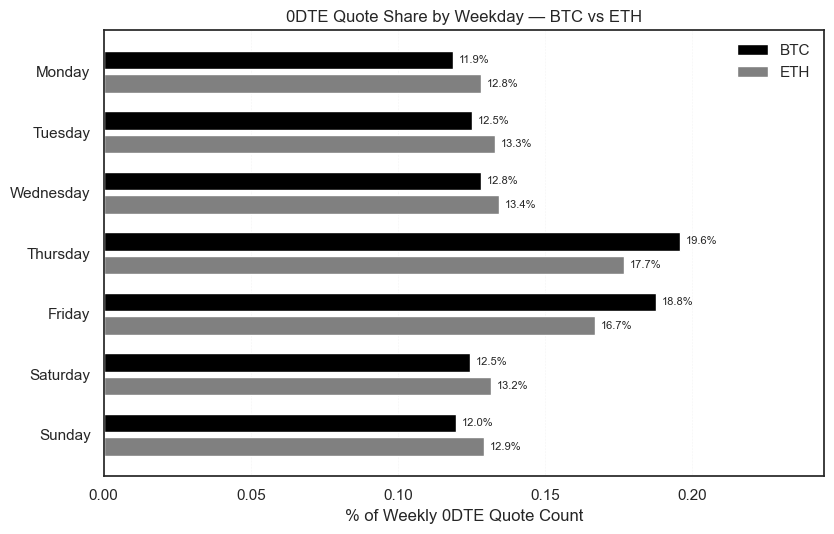

In [ ]:
all_csv_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.csv')])
COLORS = {'BTC': 'black', 'ETH': 'gray'}
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# aggregate 0DTE volumes by weekday 
shares_per_coin = {}

for coin in COINS:
    coin = coin.lower()
    weekday_counts = {day: 0 for day in DAYS}

    for file in all_csv_files:
        df = pd.read_csv(os.path.join(DATA_DIR, file))

        df[['coin', 'expiry_raw', 'strike_raw', 'cp']] = df['symbol'].str.split('-', expand=True)
        df['coin'] = df['coin'].str.lower()
        df = df[df['coin'] == coin]

        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
        df['expiry'] = (pd.to_datetime(df['expiry_raw'], format='%d%b%y', errors='coerce') + pd.Timedelta(hours=8)).dt.tz_localize('UTC')
        df['time_to_maturity'] = (df['expiry'] - df['timestamp']).dt.total_seconds()
        df = df[df['time_to_maturity'] > 0] 
        df['DTE'] = (np.ceil(df['time_to_maturity'] / 86_400) - 1).astype('Int64')    
        df = df[df['DTE'] == 0].copy()

        df['day_of_week'] = df['timestamp'].dt.day_name()

        daily_counts = df.groupby('day_of_week')['symbol'].nunique()
        for day in DAYS:
            weekday_counts[day] += daily_counts.get(day, 0)

    total_count = sum(weekday_counts.values())
    weekday_share = {day: (weekday_counts[day] / total_count) if total_count > 0 else 0 for day in DAYS}
    shares_per_coin[coin.upper()] = weekday_share

btc_vals = [shares_per_coin['BTC'][day] for day in DAYS]
eth_vals = [shares_per_coin['ETH'][day] for day in DAYS]

y_pos = np.arange(len(DAYS))
bar_h = 0.35
gap = 0.04
btc_y = y_pos - bar_h / 2 - gap / 2
eth_y = y_pos + bar_h / 2 + gap / 2

fig, ax = plt.subplots(figsize=(8.5, 5.5))
bars_btc = ax.barh(btc_y, btc_vals, height=bar_h-gap, color=COLORS['BTC'], label='BTC')
bars_eth = ax.barh(eth_y, eth_vals, height=bar_h-gap, color=COLORS['ETH'], label='ETH')
for bars in [bars_btc, bars_eth]:
    for bar in bars:
        w = bar.get_width()
        ax.text(w + 0.002, bar.get_y() + bar.get_height()/2,
                f'{w*100:.1f}%', va='center', fontsize=8)

ax.set_yticks(y_pos)
ax.set_yticklabels(DAYS)
ax.set_xlabel('% of Weekly 0DTE Quote Count')
ax.set_xlim(0, max(btc_vals + eth_vals) * 1.25)
ax.set_title('0DTE Quote Share by Weekday — BTC vs ETH')
ax.grid(True, axis='x', linestyle=':', linewidth=0.4, alpha=0.4)
ax.legend(loc='upper right', frameon=False)
ax.invert_yaxis()

plt.tight_layout()
plt.show()
